In [25]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [1]:
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
import sympy
from scipy.linalg import expm
import scipy.constants as sc
from tqdm import tqdm_notebook
from scipy.fft import fft,ifft,fftfreq, dct, idct
from itertools import combinations
import pandas as pd
import seaborn as sns
from objsize import get_deep_size
from scipy import linalg
import datetime
import os
from scipy.sparse import csc_matrix
import matplotlib.ticker as ticker

C:\Users\david\anaconda3\lib\site-packages\ipykernel_launcher.py:324: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Which Model? Deph = 0, Heisenberg XXX = 1, non H XXX = 2, no specific model=30
Save Data?0
Add to average?0
mean r value = 0.6454738163789224
mean cos(theta) = 0.25896398043562224
mean theta = 0.009350061393659027
Setting up plots


C:\Users\david\anaconda3\lib\site-packages\ipykernel_launcher.py:358: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


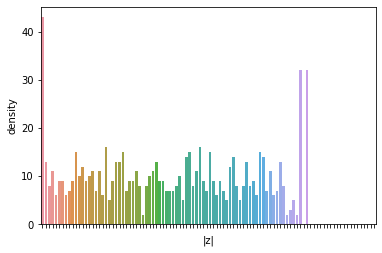

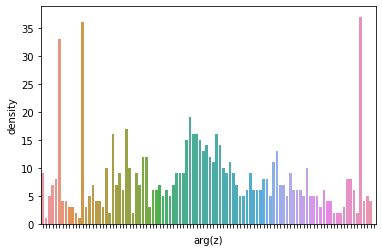

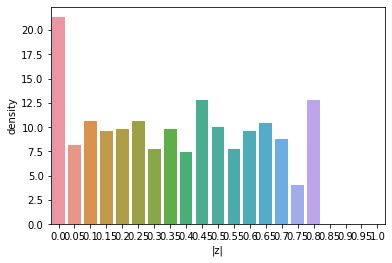

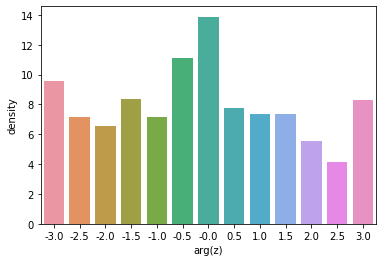

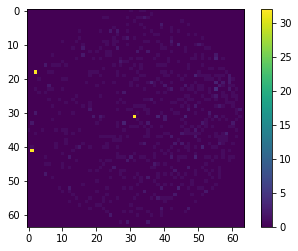

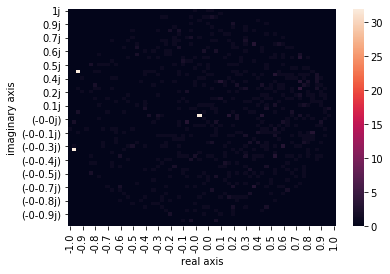

In [40]:
class lindbladian_Louville_operator():
    def __init__(self,N,h,J,b,t,tau,nv,NH,
                gamma0,gamma_L_plus,gamma_L_min,gamma_R_plus,gamma_R_min):
        
        for local in locals().copy(): 
            ## equivalent of writing self.gamma = gamma,self.b = b etc.
            ## without having to rewrite it.
            exec('self.' + local +  ' = locals()[local]')
        
        ###initialising variables so they don't have to called in 
        ###each function
        self.initialise_variables()
        
        ##calls function to create the Liouvillian
        self.L = self.L()
        
        ##calls function to create P and solve for the eigenenergies.
        self.P,self.evecs,self.evals = self.P()
        
        ##calls function to create z_k along with the degeneracy factor of each ratio
        self.z_k, self.deg_factor = self.z_k(self.evals)
        
        ##choice of model
        self.model_choice = int(input('Which Model? Deph = 0, Heisenberg XXX = 1, non H XXX = 2, no specific model=3'))
        
        ##choice of whether to save data
        self.save_boolean = bool(int(input('Save Data?')))
        self.add_to_average = int(input('Add to average?'))
        
        ##defines path for my computer
        self.path = 'C://Users/david/OneDrive/Documents/UNI/UCL project/data/'  
    
        ##retrieves the single number signatures of the data and prints them.
        self.mean_r, self.mean_cos, self.mean_theta = self.single_number_signatures(self.z_k)
        
        print('mean r value = '+ str(self.mean_r))
        print('mean cos(theta) = '+str(self.mean_cos))
        print('mean theta = '+str(self.mean_theta))
        
        ##list of all parameters needed
        data_list = ['mean_r='+str(self.mean_r),
                     'mean_cos='+str(self.mean_cos),
                     'mean_theta='+str(self.mean_theta),
                     'N='+str(self.N),'h='+str(self.h),
                     'J='+str(self.J),'b='+str(self.b),
                     't='+str(self.t),'tau='+str(self.tau),
                     'nv='+str(self.nv),'gamma0='+str(self.gamma0),
                     'gamma_L_plus='+str(self.gamma_L_plus),
                     'gamma_L_min='+str(self.gamma_L_min),
                     'gamma_R_plus='+str(self.gamma_R_plus),
                     'gamma_R_min='+str(self.gamma_R_min)]
        ##as array
        data_array = np.asarray((self.mean_r,self.mean_cos,
                     self.mean_theta,self.N,self.h,
                     self.J,self.b,self.t,self.tau,
                     self.nv,self.gamma0,self.gamma_L_plus,
                     self.gamma_L_min,self.gamma_R_plus,
                     self.gamma_R_min))
        
        
        
            
        if self.save_boolean:
            ##sorting names
            list_name = 'list, N = '+str(self.N) + ', h = '+str(self.h) +', ' +str(datetime.datetime.today().date())
            array_name = 'array, N = '+str(self.N) + ', h = '+str(self.h) +', ' +str(datetime.datetime.today().date())
            heatmap_data_name = 'heatmap matrix, N = '+str(self.N) + ', h = '+str(self.h) +', ' +str(datetime.datetime.today().date())
            
            ##sorting paths 
            self.SNS_path = self.path +'Single Number Signatures/'
            self.z_k_path =self.path + 'z_k raw data/'
            self.list_path = self.SNS_path+list_name
            self.array_path = self.SNS_path+array_name
            
            if self.add_to_average:
                ##calls function to average data with all previous relevant simulations 
                self.averaging_data(self.model_choice,self.z_k_path,data_list=data_list)
            
            ##Sorting where to save the data
            ##Deph model
            if self.model_choice==0:
                self.z_k_path = self.z_k_path+'Deph/'
                self.heatmap_path = self.z_k_path+heatmap_data_name
                if not os.path.isdir(self.z_k_path):
                    os.mkdir(self.z_k_path)
            
            ##Heisenberg model
            if self.model_choice==1:
                self.z_k_path = self.z_k_path+'Heisenberg XXX/'
                self.heatmap_path = self.z_k_path+heatmap_data_name
                if not os.path.isdir(self.z_k_path):
                    os.mkdir(self.z_k_path)
            ##non-Heisenberg XXX model
            if self.model_choice==2:
                self.z_k_path = self.z_k_path+'non H XXX/'
                self.heatmap_path = self.z_k_path+heatmap_data_name
                if not os.path.isdir(self.z_k_path):
                    os.mkdir(self.z_k_path)
            
            self.z_k_path_final = self.z_k_path+'z_k, N = '+str(self.N) + ', h = '+str(self.h) +', ' +str(datetime.datetime.today().date())
                        
            np.save(self.z_k_path_final+'.npy',self.z_k)
            np.save(self.list_path+'.npy',data_list)
            np.save(self.array_path+'.npy',data_array)
        
        ##plots data
        self.heatmap(self.z_k,self.deg_factor)
        
    def averaging_data(self,model_choice,path,data_list): 
        ##if the average has not been done before, the file must first be created
        trig = int(input('First time inputing data for the average of this model?'))

        if model_choice == 0:
            if trig:
                ##creates a list of size 3, with the inputs being
                ##the data, the number of datasets added and the parameters (data_list) respectively.
                z_k_av = [self.z_k,1,data_list]
                np.save(path+'N=' + str(self.N) +' , b=' +str(self.b)+', Deph average.npy', z_k_av)
            else: 
                ##loading the average of previous simulations
                z_k_av = np.load(path+'N=' + str(self.N) +' , b=' +str(self.b)+', Deph average.npy',
                                allow_pickle=True)
                ##checking to see if they both have the same parameters
                if data_list != z_k_av[-1]:
                    raise AttributeError('Trying to add two sets of data with different parameters')
                else:
                    ##adding to the average data mathematically.
                    z_k_av_updated = []
                    z_k_av_updated.append((z_k_av[1]*z_k_av[0] + self.z_k)/(z_k_av[1]+1))
                    z_k_av_updated.append(z_k_av[1]+1)
                    z_k_av_updated.append(data_list)
                    
                    np.save(path+'N=' + str(self.N) +' , b=' +str(self.b)+', Deph average.npy', z_k_av_updated)
        
        
        if model_choice == 1:
            if trig:
                z_k_av = [self.z_k,1,data_list]
                np.save(path+'N=' + str(self.N) +' , b=' +str(self.b)+', Heisenberg XXX average.npy', z_k_av)
            else:    
                z_k_av = np.load(path+'N=' + str(self.N) +' , b=' +str(self.b)+', Heisenberg XXX average.npy',
                                allow_pickle=True)
                
                if data_list != z_k_av[-1]:
                    raise AttributeError('Trying to add two sets of data with different parameters')
                else:
                    z_k_av_updated = []
                    z_k_av_updated.append((z_k_av[1]*z_k_av[0] + self.z_k)/(z_k_av[1]+1))
                    z_k_av_updated.append(z_k_av[1]+1)
                    z_k_av_updated.append(data_list)

                    np.save(path+'N=' + str(self.N) +' , b=' +str(self.b)+', Heisenberg XXX average.npy', z_k_av_updated)

        if model_choice == 2:
            if trig:
                z_k_av = [self.z_k,1,data_list]
                np.save(path+'N=' + str(self.N) +' , b='+ str(self.b)+', non H XXX average.npy', z_k_av)
            else:    
                z_k_av = np.load(path+'N=' + str(self.N) +' , b=' +str(self.b)+', non H XXX average.npy',
                                allow_pickle=True)

                if data_list != z_k_av[-1]:
                    print(data_list)
                    print(z_k_av[-1])
                    raise AttributeError('Trying to add two sets of data with different parameters')
                else:
                    z_k_av_updated = []
                    z_k_av_updated.append((z_k_av[1]*z_k_av[0] + self.z_k)/(z_k_av[1]+1))
                    z_k_av_updated.append(z_k_av[1]+1)
                    z_k_av_updated.append(data_list)

                    np.save(path+'N=' + str(self.N) +' , b='+ str(self.b)+', non H XXX average.npy', z_k_av_updated)



    def initialise_variables(self,):

        ####gamma is an array of 5 constants that control the dissipation 

        si = qeye(2) #identity for a spin-1/2 particle
        sz = sigmaz() ## z pauli matrix
        sx = sigmax() ## x pauli matrix
        sigp = sigmap() ##plus ladder operator for spin 1/2
        sigm = sigmam() ##minus ladder operator for spin 1/2
        sz_list = []
        sx_list = []
        sigp_list = []
        sigm_list = []
        h_arr = np.random.uniform(-self.h,self.h,self.N) ##random uniform distribution from -h to h

        for n in range(self.N):
            op_list = []
            for m in range(self.N):
                op_list.append(si) ##creates a list of identity operators for each particle
            self.identity = tensor(op_list) ##creates an identity over the 4^N x 4^N space
            op_list[n] = sz
            sz_list.append(tensor(op_list))

            op_list[n] = sx
            sx_list.append(tensor(op_list))
            ###could get greater efficiency by just calculating the plus/minus 
            ### at the boundaries where they're needed
            if n==0:
                op_list[n] = sigp
                sigp_list.append(tensor(op_list))

                op_list[n] = sigm
                sigm_list.append(tensor(op_list))
            if n==self.N-1:
                op_list[n] = sigp
                sigp_list.append(tensor(op_list))

                op_list[n] = sigm
                sigm_list.append(tensor(op_list))

        # construct the hamiltonian 
        H_S = 0
         ##bulk dephasing
        W_list = [] ##list of jump operators

        # energy splitting terms
        for n in range(self.N):
            H_S += h_arr[n] * sz_list[n] ##random field term

            ##bulk dephasing
            W_list.append(np.sqrt(self.gamma0) * sz_list[n])
        
        ##amplitude damping
        W_list.append(np.sqrt(self.gamma_L_plus)*sigp_list[0]) ##W_{N+1}
        W_list.append(np.sqrt(self.gamma_L_min)*sigp_list[1]) ##W_{N+2}
        W_list.append(np.sqrt(self.gamma_R_plus)*sigm_list[0]) ##W_{N+3}
        W_list.append(np.sqrt(self.gamma_R_min)*sigm_list[1]) ##W_{N+4}
                
        
        self.W_list = W_list
        self.sigp_list = sigp_list
        self.sigm_list = sigm_list

        # interaction terms
        for n in range(self.N-1): 
            H_S += self.J * sz_list[n] * sz_list[n+1]

        self.H1 =H_S
        ##kicking term
        self.Hk = 0
        for n in range(self.N):
                self.Hk += self.b * sx_list[n]

    def L(self,):
        ###creates L from the definition of its matrix representation, 
        ###equation 4.1 of the notes currently
        
        W_term = 0 
        ###calculates sum_{\mu}(W_{\mu}^{\dag}*W_{\mu})
        for i in range(len(self.W_list)):
            W_term += self.W_list[i]*(self.W_list[i].dag())
               
        H_left = self.H1 - (1j/2)*W_term
        H_right = self.H1 + (1j/2)*W_term

        H_cross_term = 0
        ##calculates  sum_{\mu}(W_{\mu}\otimes W_{\mu}^{\dag})
        for i in range(len(self.W_list)):
            H_cross_term += tensor(self.W_list[i],self.W_list[i].dag())

        L = -1j*tensor(H_left,self.identity)
        L += 1j*tensor(self.identity,H_right.trans())
        L += H_cross_term
        return L
    
    def P(self,):
        
        ##reducing the precision of Qobjs to reduce data size
        #self.L[:] = self.L[:].astype(np.csingle)
        #self.Hk[:] = self.Hk[:].astype(np.csingle)
        #self.identity[:] = self.identity[:].astype(np.csingle)
        
        ##using tidyup doesnt do much
        #self.L.tidyup()
        #self.Hk.tidyup()
        #self.identity.tidyup()
        
        if self.t>(self.tau/2):
            ##defining the commutator kicking superoperator
            HK_commute_SO = -1j*tensor(self.Hk,self.identity)
            HK_commute_SO += 1j*tensor(self.identity,self.Hk.trans())
        
        ###exponentiates the matrices and calculates P
            expH = HK_commute_SO.expm()
            exp1 = (self.L*self.tau/2).expm()
            exp2 = (self.L*(self.t-self.tau/2)).expm()
            P = exp2*(expH*exp1)
        if self.t<=self.tau/2:
            P = (self.L*self.t).expm()
        
        evals = P.eigenstates()[0]
        evecs = P.eigenstates()[1]
        

#         """array method to try and reduce data"""
#         L_arr = np.asarray(self.L,dtype=np.complex64)
#         Hk_arr = np.asarray(HK_commute_SO,dtype=np.complex64)
#         identity_arr = np.asarray(self.identity,dtype=np.complex64)
        
#         expH_arr = linalg.expm(Hk_arr)
#         exp1_arr = linalg.expm(L_arr*self.tau/2)
#         exp2_arr = linalg.expm(L_arr*(self.t - self.tau/2))
        
#         P_arr = exp2_arr*(expH_arr*exp1_arr)
#         P = Qobj(P_arr)
        
        return P,evecs,evals
    


    '''''''''''''''''Level Statistics functions'''''''''''''''''
    def z_k(self,E_array):
        z_k = [] ##setting up ratio array
        
        ##removes degeneracy
        self.E_array_no_deg = np.unique(E_array)
        ##saves the degeneracy factors of all the energies
        deg_factor = np.unique(E_array,return_counts=True)[-1]
        for i in tqdm_notebook(range(np.size(self.E_array_no_deg)),leave=False):
                
            ##creating an array of the indices of the ratios ascending in magnitude from 
            ##the ith ratio
            E_idx_sorted = np.argsort(np.abs(self.E_array_no_deg-self.E_array_no_deg[i]))
            
            ##takes the first one
            NN = self.E_array_no_deg[E_idx_sorted[1]] 
            diff1 = NN-self.E_array_no_deg[i]
            ##takes the second one
            NNN = self.E_array_no_deg[E_idx_sorted[2]] 
            diff2 = NNN-self.E_array_no_deg[i]
            
            ##definition of z_k
            z_k.append(diff1/diff2)
        z_k = np.asarray(z_k) 
        return z_k, deg_factor

    
    def heatmap(self,z_k,deg_factor):
        print('Setting up plots')
        
        ##creating grid in complex space
        real_vals = np.linspace(-1,1,self.nv)
        imag_vals = 1j*np.linspace(-1,1,self.nv)
        
        ##creating empty 2D array for heatmap values
        heatmap_vals = np.zeros((self.nv,self.nv)) 
        r_vals =  np.zeros((self.nv,self.nv))
        theta_vals =  np.zeros((self.nv,self.nv))
        
        ##resolution of grid
        delta = (np.max(real_vals)-np.min(real_vals))/np.size(real_vals)
        
        for i in tqdm_notebook(range(self.nv),leave=False):
            for j in range(self.nv):
                ##recentres z_k so origin is at (real_vals[i],imag_vals[j])
                recentred_z_k = z_k - real_vals[i] - imag_vals[j]
                
                #defining r at this point
                r_ij = np.abs(real_vals[i] + imag_vals[j])
                
                #defining theta at this point
                theta_ij = np.angle(real_vals[i]+imag_vals[j])
                
                ##creates booleans in order to get rid of any values
                ##that don't lie in the ith,jth square of the grid
                real_bool =(recentred_z_k.real>=0)*(recentred_z_k.real<=delta) 
                imag_bool =(recentred_z_k.imag>=0)*(recentred_z_k.imag<=delta)
    
    
                ##summing up how many non-zero values there are,
                ##which is then multiplied by the degeneracy factor of each distinct eigenenergy.
                rho = np.sum(real_bool*imag_bool*deg_factor)
                heatmap_vals[j,i] = rho ##python indices are opposite to matrix convention
                
                ##sets the r value for the ith, jth element of the grid
                r_vals[j,i] = r_ij 
                
                ##sets the theta value for the ith, jth element of the grid
                theta_vals[j,i] = theta_ij
        
        self.theta_vals = theta_vals
        self.heatmap_vals = heatmap_vals
        
        
        ##self.NH defines the number of histograms
        theta_array = np.linspace(-np.pi,np.pi,self.NH)
        r_array = np.linspace(0,1,self.NH)
        theta_hists = np.zeros(self.NH)
        r_hists = np.zeros(self.NH)
        
        ###flattens theta values and sorts them in order of size into a 1D array.
        flattened_theta_vals = theta_vals.flatten()
        flattened_theta_vals_sorted = flattened_theta_vals[np.argsort(theta_vals,axis=None)]
        
        ###flattens r values and sorts them in order of size into a 1D array.
        flattened_r_vals = r_vals.flatten()
        flattened_r_vals_sorted = flattened_r_vals[np.argsort(r_vals,axis=None)]
        
        ##ordering heatmap values in order of increasing theta_vals
        flattened_vals_theta = heatmap_vals.flatten()[np.argsort(theta_vals,axis=None)]
        
        ##ordering heatmap values in order of increasing r_vals
        flattened_vals_r = heatmap_vals.flatten()[np.argsort(r_vals,axis=None)]
        
        ##array of indices
        indices = np.linspace(0,np.size(flattened_theta_vals),self.NH)
        
        ##for loop that sums the z_k ratios in the given band of theta or r
        for i in range(self.NH-1):
            I1 = int(np.round(indices[i]))
            I2 = int(np.round(indices[i+1]))
            theta_hists[i] = np.sum(flattened_vals_theta[I1:I2])
            r_hists[i] = np.sum(flattened_vals_r[I1:I2])
        
        ##making the local variables global (just so debugging is easier)
        self.r_array = r_array
        self.r_hists = r_hists
        self.theta_array = theta_array
        self.theta_hists = theta_hists
        
        
        ax = sns.barplot(x=r_array,y=r_hists)
        ax.set(xlabel = '|z|',ylabel = 'density',xticklabels=[])
        
        #ax.yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing_y))
        #ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing_x))
        plt.show()
        
        ax = sns.barplot(x=theta_array,y=theta_hists)
        ax.set(xlabel = 'arg(z)',ylabel = 'density',xticklabels=[])
        plt.show()
        
        
        r_rounded = (np.round(2*self.r_array,1))/2
        theta_rounded = np.round(2*self.theta_array)/2
        
        ax = sns.barplot(x=r_rounded,y=r_hists,ci=None)
        ax.set(xlabel = '|z|',ylabel = 'density')
        plt.show()
        
        ax = sns.barplot(x=theta_rounded,y=theta_hists,ci=None)
        ax.set(xlabel = 'arg(z)',ylabel = 'density')
        plt.show()
  
        ##plots heatmap
        plt.imshow(heatmap_vals)
        plt.colorbar()
        plt.show()
        
       
        ##plotting a seaborn heatnap
        df = pd.DataFrame(data=heatmap_vals,index = np.round(-imag_vals,1), columns=np.round(real_vals,1))
        sns.heatmap(df)
        plt.xlabel('real axis')
        plt.ylabel('imaginary axis')
        if self.save_boolean:
            plt.gcf().tight_layout()
            #self.graph_path = 'heatmap , N = '+str(self.N) + ', h = '+str(self.h) +', ' +str(datetime.datetime.today().date())
            plt.savefig(self.heatmap_path+'.png',dpi=250)
            
        plt.show()

    
    def single_number_signatures(self,z_k):
        theta = np.angle(z_k)
        cos_theta = np.cos(theta)
        mean_cos = np.mean(cos_theta)
        mean_theta = np.mean(theta)
        r = np.abs(z_k)
        mean_r = np.mean(r)
        return mean_r, mean_cos, mean_theta
    

method = lindbladian_Louville_operator(N=5,h=0,J=1,b=0,
                                       t=0.7,tau=1,nv=64,
                                       NH=100,
                                       gamma0=0,gamma_L_plus=0.5,gamma_L_min=0.3,gamma_R_plus=0.3,gamma_R_min=0.9)

In [36]:
x = np.load('C://Users/david/OneDrive/Documents/UNI/UCL project/data/z_k raw data//N=5 , b=0, non H XXX average.npy',allow_pickle=True)


In [39]:
x[1]

2

In [22]:
np.load(method.z_k_path+'N=' + str(method.N) +' , b=' +str(method.b)+', non H XXX average'+'.npy')

FileNotFoundError: [Errno 2] No such file or directory: 'C://Users/david/OneDrive/Documents/UNI/UCL project/data/z_k raw data/non H XXX/N=5 , b=0, non H XXX average.npy'

In [40]:
def averaging_data(model_choice,N):
    if 
    if self.N = 5:
        
    if self.N = 6:

        
    np.load(method.z_k_path+'.npy')


array([-1.70660060e-04+4.47265512e-02j, -1.70660060e-04-4.47265512e-02j,
        9.50270828e-01+2.17028489e-01j, ...,
        9.14724955e-01-8.37703229e-15j, -8.61533109e-01+1.68213228e-14j,
        5.37191627e-01+4.85421061e-15j])

In [32]:
(np.round(2*method.r_array,1))/2

array([0.  , 0.  , 0.  , 0.05, 0.05, 0.05, 0.05, 0.05, 0.1 , 0.1 , 0.1 ,
       0.1 , 0.1 , 0.15, 0.15, 0.15, 0.15, 0.15, 0.2 , 0.2 , 0.2 , 0.2 ,
       0.2 , 0.25, 0.25, 0.25, 0.25, 0.25, 0.3 , 0.3 , 0.3 , 0.3 , 0.3 ,
       0.35, 0.35, 0.35, 0.35, 0.35, 0.4 , 0.4 , 0.4 , 0.4 , 0.4 , 0.45,
       0.45, 0.45, 0.45, 0.45, 0.5 , 0.5 , 0.5 , 0.5 , 0.55, 0.55, 0.55,
       0.55, 0.55, 0.6 , 0.6 , 0.6 , 0.6 , 0.6 , 0.65, 0.65, 0.65, 0.65,
       0.65, 0.7 , 0.7 , 0.7 , 0.7 , 0.7 , 0.75, 0.75, 0.75, 0.75, 0.75,
       0.8 , 0.8 , 0.8 , 0.8 , 0.8 , 0.85, 0.85, 0.85, 0.85, 0.85, 0.9 ,
       0.9 , 0.9 , 0.9 , 0.9 , 0.95, 0.95, 0.95, 0.95, 0.95, 1.  , 1.  ,
       1.  ])

In [29]:
np.load()

array([ 16,  16,  12,  12,  56,  56,   8,   8,  12,  12,   8,   8,  16,
        16,   8,   8,   8,   8,  56,  56,  56,  56,  56,  56,  56,  56,
        32,   1,   1,  38,   2,   2, 140,   1,   1,  38,  32], dtype=int64)

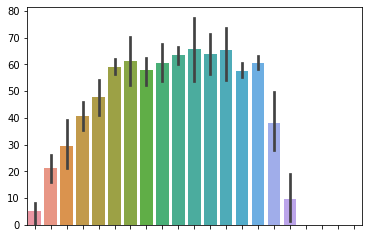

In [36]:
ax = sns.barplot(x=(np.round(2*method.r_array,1))/2,y=method.r_hists)
ax.set(xticklabels=[])
plt.show()

In [60]:
method.z_k[:10]

array([ 0.88739762+0.00280623j,  0.88739762-0.00280623j,
        0.44069376+0.06934655j,  0.44069376-0.06934655j,
        0.96841874-0.01021154j,  0.96841874+0.01021154j,
       -0.76086009-0.21832328j, -0.76086009+0.21832328j,
       -0.6711155 -0.09726853j, -0.6711155 +0.09726853j])

AttributeError: 'numpy.ndarray' object has no attribute 'get'

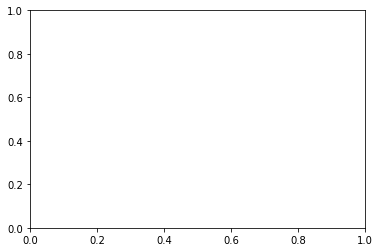

In [53]:


df = pd.DataFrame()


sns.barplot(x='method.r_array',y='method.r_hists',data=method.r_hists,ax=ax)
ax.set(xlabel = '|z|',
              ylabel = 'density',
              xticklabels=[])
ax.set_xlim(0,100)
plt.show()
# ax = sns.barplot(x=method.theta_array,y=method.theta_hists)
# ax.set(xlabel = 'arg(z)',
#               ylabel = 'density',
#               xticklabels=[])
# plt.show()
        

In [52]:
sns.set_theme(style="whitegrid")
tips = sns.load_dataset("tips")
ax = sns.barplot(x="day", y="total_bill", data=tips)

AttributeError: module 'seaborn' has no attribute 'set_theme'

In [95]:


###works up up to the limit**2 for precision (limit of the while loop)
def my_expm(A):
    ####reduces precision
    A = np.asarray(A)
    
    m,n = np.shape(A)
    k = 0
    fact = 1
    matpow = np.eye(n)
    expmat = np.matrix(np.zeros([n,n]))
    lastnorm = 1
    while lastnorm > 1e-4:
        expmat = expmat + matpow/fact
        lastnorm = np.max(abs(matpow/fact))
        k += 1
        if k ==170: ##computer can't handle factors when they're this large
            break
        fact *= k
        matpow = A@matpow
        if k%10 ==0:
            print(k)
    return expmat


#do diagonalisation method for expA
def my_expm2(A):
    m,n = np.shape(A)
    evecs = A.eigenstates()[1]
    evals = A.eigenstates()[0]
    diag_A = np.diag(evals)
    D = np.zeros(np.shape(A),dtype=np.csingle)
    for i in range(n):
        D[:,i] = np.asarray(evecs[i]).reshape(n)
    D = Qobj(D)
    D_inv = D.inv()
    k = 0
    fact = 1
    matpow = np.eye(n)
    expmat = np.matrix(np.zeros([n,n]))
    lastnorm = 1
    while lastnorm > 1e-4:
        expmat = expmat + matpow/fact
        lastnorm = np.max(abs(matpow/fact))
        k += 1
        fact *= k
        matpow = matpow*diag_A
    expmat = Qobj(expmat)
    expmat = D*(expmat*D_inv)

    return expmat

In [ ]:
x = csc_matrix(np.asarray(method.L))

def my_expm3(A): ###using gensim
    m,n = np.shape(A)
    evecs = A.eigenstates()[1]
    evals = A.eigenstates()[0]
    diag_A = np.diag(evals)
    D = np.zeros(np.shape(A),dtype=np.csingle)
    for i in range(n):
        D[:,i] = np.asarray(evecs[i]).reshape(n)
    D = Qobj(D)
    D_inv = D.inv()
    k = 0
    fact = 1
    matpow = np.eye(n)
    expmat = np.matrix(np.zeros([n,n]))
    lastnorm = 1
    while lastnorm > 1e-4:
        expmat = expmat + matpow/fact
        lastnorm = np.max(abs(matpow/fact))
        k += 1
        fact *= k
        matpow = matpow*diag_A
    expmat = Qobj(expmat)
    expmat = D*(expmat*D_inv)

    return expmat  

In [12]:
x = csc_matrix(np.asarray(method.L))

In [5]:
x = sp.sparse.random(1600,1600,density=0.1)
x = x.tocsc()

NameError: name 'sp' is not defined

In [9]:
import gensim
from gensim.test.utils import common_dictionary, common_corpus
import gensim.models
from gensim.models import LsiModel


In [25]:
U,s = gensim.models.lsimodel.stochastic_svd(np.abs(x), 
                                      rank=4096,
                                      num_terms = 4096,
                                      chunksize=100,)

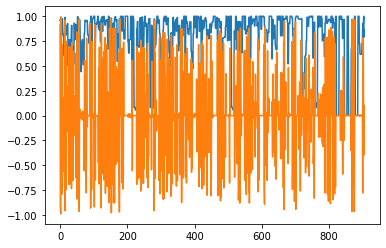

In [99]:
coords = np.asarray(range(906))
plt.plot(coords,np.abs(method.z_k))
plt.plot(coords,method.z_k.imag)
plt.show()

In [46]:
x = np.asarray((5000j,3,3,3,5,2,8,7,6,6),dtype=np.complex128)
np.unique(x)

array([0.+5000.j, 2.   +0.j, 3.   +0.j, 5.   +0.j, 6.   +0.j, 7.   +0.j,
       8.   +0.j])

In [ ]:
       
        
        #         trig1 = True
#         k=0
        
        
#         while trig1:
#         #for i in tqdm_notebook(range(np.size(E_array)),leave=False):
            
#             ##This parameter gives the degeneracy of the kth group of eigenenergies.
#             z_k_deg_k = 1
#             ##This parameter gives the degeneracy of the nearest neighbour of the kth group of eigenenergies,
#             ##where 'group' means a subset of equal eigenenergies.
#             z_k_degNN = 1
            
            
#             ###creating an array of the indices of the ratios ascending in magnitude from 
#             ##the ith ratio
#             E_idx_sorted = np.argsort(np.abs(E_array-E_array[k]))
            
#             ##The following while loop assigns the nearest and next nearest neighbours for 
#             ##the kth value of E_array, and if any difference is zero (degeneracies) the loop 
#             ##keeps moving until a non degenerate value is found
#             trig2 = True
#             i=1
#             n=1
#             while trig2:
#                 ##takes the first one (and then kth one if there are degeneracies)
#                 NN = E_array[E_idx_sorted[i]] 
                
#                 ##boolean for whether NN is degenerate with E_array[k]
#                 bool_NN = (NN!=E_array[k])
#                 if bool_NN:
#                     NNN = E_array[E_idx_sorted[i+n]] ##takes the second one
#                     bool_NNN = (NNN!=NN)
#                     if bool_NNN:
#                         E_array_updated = 
#                         trig2 = False
#                     n += 1
#                     z_k_degNN += 1
#                 i += 1
#                 z_k_deg_k += 1
                
#                 ###IM OVERCOUNTING DEGENERACIES
                
#             ##definition of z_k
            
#             z_k.append((NN-E_array[i])/(NNN-E_array[i]))
            
#             ##z_k_deg_k only matters for k==0, for k>0 the code has already considered the degeneracy of
#             ##E_array[k] via z_k_degNN in the previous iteration.
#             if k==0: 
#                 z_k_deg.append(z_k_deg_k)
#                 k += z_k_deg_k
            
#             z_k_deg.append(z_k_degNN)
#             k += z_k_degNN
            
            
            
            ##THIS IS WRONG AS E_array ISNT ORDERED INITIALLY
            
            
            
            
            ##This for loop stops the while loop when all of the E_array elements have been evaluated
            if k == np.size(E_array):
                trig1 = False 
        
        
        
            
#         for i in range(self.NH-1):
#             ##summing up array of truths and falses where the r value 
#             ##falls in r_array[i]<r<r_array[i+1]
#             radial_bool = (r_vals>=r_array[i])*(r_vals<=r_array[i+1])
#             R_Hists[i] = np.sum(heatmap_vals*radial_bool)
        
#         for j in range(self.NH-1):
#                 ##same for theta
#                 theta_bool = (theta_vals>=theta_array[i])*(theta_vals<=theta_array[i+1])
#                 Theta_Hists[j] = np.sum(heatmap_vals*theta_bool)
        